In [88]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import numpy as np
import re
import os

In [2]:
os.getcwd()

'/home/jovyan/work/Starbucks_Clustering'

# Learning Objective: Hierarchical clustering with Python Code

A newly opened Starbucks coffee shop manager wanted to increase loyal customer to his newly opened shop. As part of increasing customer loyalty, he collected data of sale of hot beverages vs popular times of a typical day - in this case Wednesday. The goal of the manager is to offer a sales coupons to customers based on time visit to the store.

He consulted you, data scientist, and wanted you to develop clustering (maximum three popular time slots of the day to offer coupon). How do you approach?

 

Part B: Please upload Cluster Source code & Output for Single Link, Complete Link and Average Link. (10)

# Accessing the Data

In [ ]:
# We have data for multiple beverage types, so we can cater our coupons to customers particular of coffee
bev_keys = pd.read_csv('./Beverage_key.csv')
# We have data for the times the beverages in bev_keys were bought
bev_times = pd.read_csv('./Beverage_times.csv')
# We have data for only Wednesdays
# PTIndex (Popular Time Index) as the foreign key to bev_times
# HBIndex (Hot Beverage Index) as the foreign key to bev_keys
bev_days = pd.read_csv('./Beverage_days.csv')

In [14]:
print(bev_days.head())
print(bev_keys.head())
print(bev_times.head())

     Weekday  PTIndex  HBIndex
0  Wednesday        1        5
1  Wednesday        1        7
2  Wednesday        2        6
3  Wednesday        2        9
4  Wednesday        3        6
       HOT Beverages  Index
0         CoffeeType      1
1        Café Latte       2
2         Café Mocha      3
3         Cappuccino      4
4  Caramel Macchiato      5
    Popular times  PT Index
0      6am - 7 am         1
1      7am - 8 am         2
2     8 am - 9 am         3
3      9am - 10am         4
4  10am - 12 noon         5


# Data Cleaning

In [27]:
# the first row seems to be a metadata field, so it can be dropped
bev_keys = bev_keys.drop(0)

In [29]:
bev_keys = bev_keys.set_index('Index', drop=True)

In [35]:
# used to transform the HBIndex to the beverage name
bev_dict = bev_keys.to_dict()['HOT Beverages']

In [49]:
# used to transform the PTIndex to the time range
time_dict = bev_times.set_index('PT Index', drop=True).to_dict()['Popular times']

In [43]:
# dropping the HBIndex to propogate the change made to bev_keys (dropping index 1 (CoffeeType))
bev_days = bev_days.where(bev_days.HBIndex != 1).dropna(how='all').reset_index(drop=True)

In [44]:
bev_days['Bev_Bought'] = bev_days['HBIndex'].apply(lambda x: bev_dict[x])

## Feature Engineering the Time_Bought feature

In [50]:
bev_days['Time_Bought'] = bev_days['PTIndex'].apply(lambda x: time_dict[x])

In [56]:
bev_days['Time_Bought'] = bev_days['Time_Bought'].apply(lambda x: x.replace(' ', '').replace('noon', 'pm').replace(':00', ''))

In [75]:
# Helper function to convert 12-hour format to 24-hour format
def convert_to_24hour(time_str):
    # Check if time is in pm
    is_pm = 'pm' in time_str
    
    # Extract hour as integer
    hour = int(re.sub('[^\d]', '', time_str))
    
    # Add 12 to hour if time is in pm (and not 12 pm)
    if is_pm and hour != 12:
        hour += 12
    elif not is_pm and hour == 12:
        # Adjust for 12 am
        hour = 0
    
    return hour

In [78]:
bev_days['Start_Time_24hr'] = bev_days['Time_Bought'].apply(lambda x: convert_to_24hour(x.split('-')[0]))
bev_days['End_Time_24hr'] = bev_days['Time_Bought'].apply(lambda x: convert_to_24hour(x.split('-')[1]))

## Feature Engineering the Bev_Bought Feature

In [80]:
bev_bought_encoded = pd.get_dummies(bev_days, columns=['Bev_Bought'], drop_first=True)

## Feature Selection

In [82]:
bev_bought_encoded.drop(['Weekday', 'PTIndex', 'HBIndex', 'Time_Bought'], axis=1, inplace=True)

In [83]:
bev_bought_encoded.head()

,Start_Time_24hr,End_Time_24hr,Bev_Bought_Café Latte,Bev_Bought_Café Mocha,Bev_Bought_Cappuccino,Bev_Bought_Caramel Macchiato,Bev_Bought_Coffee Of the Day,Bev_Bought_Espresso Shot,Bev_Bought_Hot Chocolate
0,6,7,False,False,False,True,False,False,False
1,6,7,False,False,False,False,False,False,True
2,7,8,False,False,False,False,False,False,False
3,7,8,False,False,False,False,True,False,False
4,8,9,False,False,False,False,False,False,False


# Clustering Functions

In [16]:
def plot_dendrogram(data, method):
    """
    Plot the dendrogram for a specific linkage method.
    """
    linked = linkage(data, method=method)
    dendrogram(linked, labels=range(data.shape[0]))
    plt.title(f'Dendrogram using {method}-link clustering')
    plt.show()
def plot_scatter(data, method, t):
    '''
    Perform single-link clustering
    '''
    linked = linkage(data, method=method)
    # Using the plot_dendogram information for t as a prior
    # Assign cluster labels based on a specific cut-off height on the dendrogram
    # You might need to adjust the 't' value depending on where you want to cut the dendrogram.
    cluster_labels = fcluster(linked, t=t, criterion='distance')

    # Plot clusters
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(np.unique(cluster_labels)):
        plt.scatter(data[cluster_labels == label, 0], data[cluster_labels == label, 1], label=f'Cluster {i+1}')

    plt.title('Clusters visualized on 2D scatter plot')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

In [90]:
def plot_scatter(data, method, t, feature_x, feature_y):
    '''
    Perform hierarchical clustering and visualize clusters in 2D scatter plot.
    
    Parameters:
        - data: DataFrame, input data for clustering
        - method: str, linkage method for hierarchical clustering
        - t: float, distance cutoff to form clusters
        - feature_x: str, name of the feature to plot on x-axis
        - feature_y: str, name of the feature to plot on y-axis
    '''
    # Compute linkage matrix
    linked = linkage(data, method=method)
    
    # Assign cluster labels
    cluster_labels = fcluster(linked, t=t, criterion='distance')
    
    # Plot clusters
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(np.unique(cluster_labels)):
        plt.scatter(data.loc[cluster_labels == label, feature_x], 
                    data.loc[cluster_labels == label, feature_y], 
                    label=f'Cluster {i+1}')

    plt.title('Clusters visualized on 2D scatter plot')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend()
    plt.show()

# Single Link

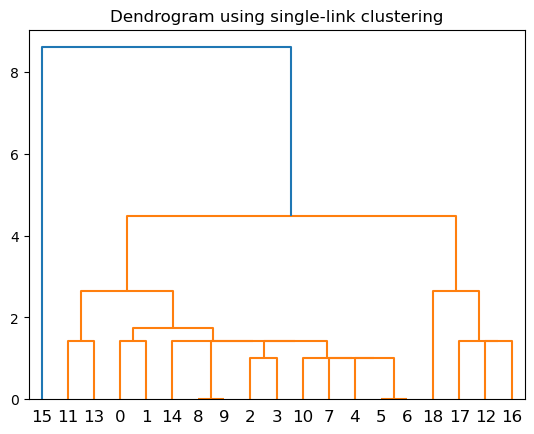

In [84]:
plot_dendrogram(bev_bought_encoded, method='single')

## Summary of Single Link

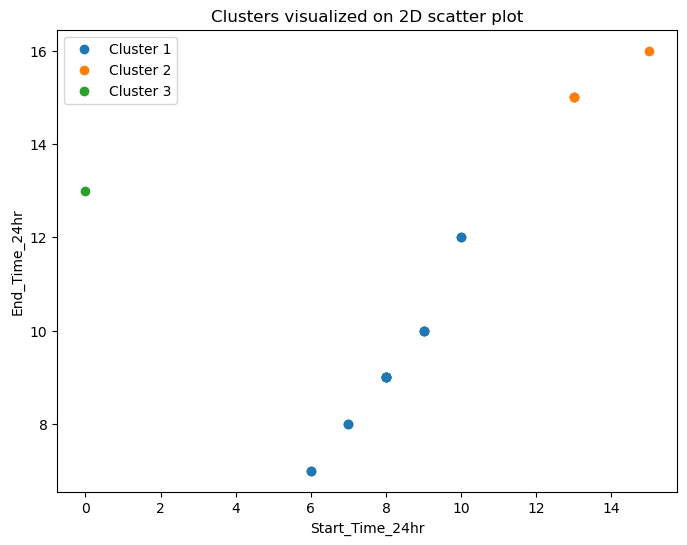

In [117]:
plot_scatter(bev_bought_encoded, method='single', t=3, feature_x='Start_Time_24hr', feature_y='End_Time_24hr')

**As the starbucks manager anticipated, we were able to identify three clusters of time-slots for offering our new coupons. The largest (By far) of all the other clusters is cluster 1, followed by cluster 2 and then cluster 3. Since cluster one is really large, the manager may want to limit the length of the cluster to 3 hours. We could find the midpoint of cluster 1 (8) and create the range 6am-9am as our primary time-slot for giving out coupons for hot beverages. For the second cluster, and for the third, length is not an issue as they are small enough, and so cluster 2 would be assigned (1pm-4pm). Finally, the 3rd cluster is for the afternoon, 12pm-1pm.**
## Time-Slots Generated
**This gives the following in order of importance:**
1. **Cluster 1 (Morning time-slot): 6am-9am** (3 hours)
2. Cluster 2 (Early Evening): 1pm-4pm (3 hours)

**Sidenote:** Cluster three only has one data point, so I would advise the starbucks manager to ignore this cluster. However, I would still mention the data being dropped was: 

Cluster 3 (High Noon):12pm-1pm (1 hour)

# Complete Link

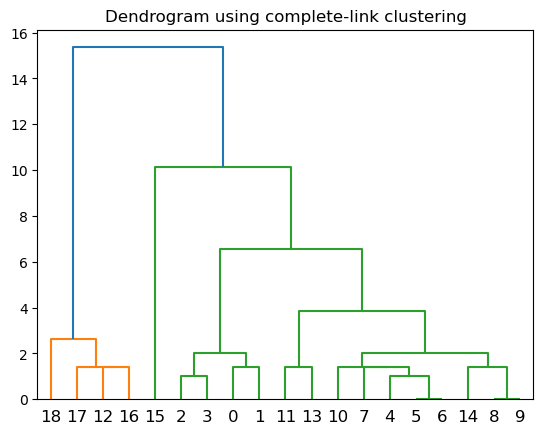

In [85]:
plot_dendrogram(bev_bought_encoded, method='complete')

## Summary of Complete Link


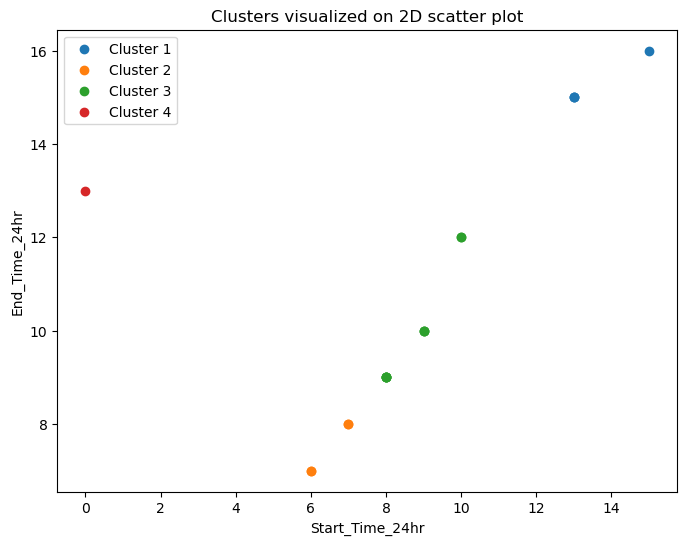

In [114]:
plot_scatter(bev_bought_encoded, method='complete', t=4, feature_x='Start_Time_24hr', feature_y='End_Time_24hr')

**According to the complete-link dendogram, T=4 is a good cut-off on the clusters using the complete method. Doing so returns 4 clusters, however. This does not align with the Starbucks manager's request to identify a maximum of three clusters/time-slots to use when offering the store coupons. As such we will drop the smallest cluster and advise the manager using the top 3 clusters to use as time-slots.** 
## Time Slots Generated
**This gives the following in order of importance:**
1. **Cluster 3 (Morning time-slot): 8am-12pm** (4 hours)
2. Cluster 2 (Early Morning): 6am-8am (2 hours)
3. Cluster 1 (Early Evening):1pm-4pm (3 hours)

**Sidenote:** Since Cluster 2/3 have similar sizes, I would advise the manager to prioritize these two time slots equally. Also, cluster 4 was dropped due to insufficient size.

# Average Link

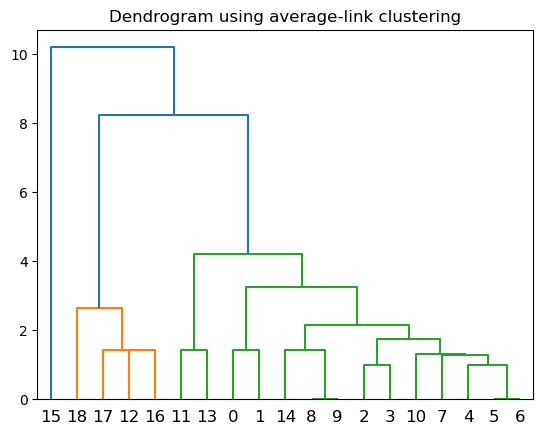

In [86]:
plot_dendrogram(bev_bought_encoded, method='average')

## Summary of Average Link

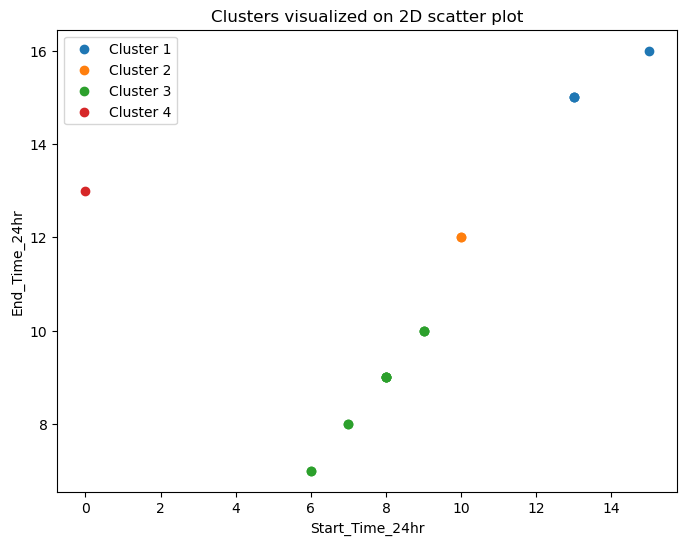

In [120]:
plot_scatter(bev_bought_encoded, method='average', t=4, feature_x='Start_Time_24hr', feature_y='End_Time_24hr')

**According to the Average Link dendogram, T=4 is the optimal cut-off for the clusters, and this gives 4 clusters. This looks different than the 4 clusters generated in the complete link method however. Now we have 2 clusters that only contain a single data point, and it would be preferable to drop these. In effect, this gives us only 2 useful clusters. Since there is no minimum number of clusters that the starbucks managers would like, we can simply advise the manager with two time-slots due to this limitation.** 
## Time Slots Generated
**This gives the following in order of importance:**
1. Cluster 3 **(Morning time-slot): 6am-10am** (4 hours)
2. Cluster 1 (Early Evening time-slot): 1pm-4pm (3 hours)

**Sidenote:** Clusters 2/4 were dropped due to insufficient size.